In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.loading import *
from src.utils import *
from src.saving import *

In [3]:
# For consistency, make some common formatting as a function and define global constants
#
def _format_axis(ax):
    ax.grid()
    ax.set_xlim(-5.5, 5.5)
    ax.set_ylim(-5.5, 5.5)
    ax.set_xlabel(r'$a_{conv}$', fontsize=12)
    ax.set_ylabel(r'$a_{strat}$', fontsize=12)

OBS_CUTOFF = 5

# IMERG data

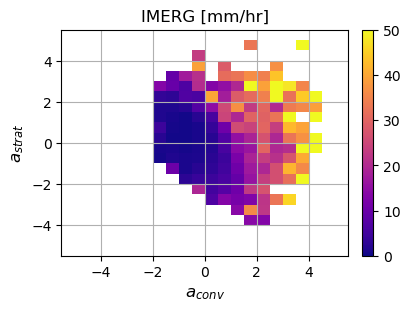

In [4]:
# Load PCs
#
pcs = load_era5_eofs_pcs().scores()
pcs = pcs.isel(time=pcs.time.dt.month==2)
pcs = pcs/pcs.std(('latitude', 'longitude', 'time'))
# Set bins for PCs and make plotting mesh
#
pc_bins = np.arange(-10, 10, 0.5)
xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))

# Load IMERG data
#
pr = load_imerg_data() * 24
pr = pr.coarsen({'lat': 20, 'lon': 20}).mean()
pr = pr.transpose('time', 'lat', 'lon')  # get to same order as ERA PCs

# Compute bin mean preicp rate
#
mean = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate first
    pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
    pr.data.ravel(), 
    statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
    bins=[pc_bins, pc_bins]
).statistic
# Plot the data
#
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=0, vmax=50),
    cmap=plt.cm.plasma.copy()
)
_format_axis(ax)
fig.colorbar(c)
ax.set_title('IMERG [mm/hr]')
save_figure(fig, 'imerg_precip.pdf')

# ERA5 Column Water

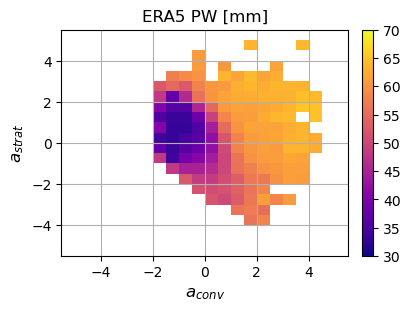

In [5]:
# Load PCs
#
pcs = load_era5_eofs_pcs().scores()
pcs = pcs.isel(time=pcs.time.dt.month==2)
pcs = pcs/pcs.std(('latitude', 'longitude', 'time'))
# Set bins for PCs and make plotting mesh
#
pc_bins = np.arange(-10, 10, 0.5)
xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))
# ERA5 Column water vapor
#
data = load_era5_tcwv()['TCWV']
# Coarsen to same resolution as PCs
#
data = data.isel({'latitude': slice(None, -1), 'longitude': slice(None, -1)}).coarsen({'latitude': 8, 'longitude': 8}).mean()
data = data.sel({'latitude': pcs.latitude, 'time': pcs.time})  # Align grids
# Compute mean
#
mean = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate first
    pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
    data.data.ravel(), 
    statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
    bins=[pc_bins, pc_bins]
).statistic
# Plot data
#
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=30, vmax=70),
    cmap=plt.cm.plasma.copy()
)
_format_axis(ax)
fig.colorbar(c)
ax.set_title('ERA5 PW [mm]')
save_figure(fig, 'era5_pw.pdf')


# CERES Cloud Radiative Effects

In [13]:
# Load PCs
#
pcs = load_era5_eofs_pcs().scores()
pcs = pcs.isel(time=pcs.time.dt.month==2)
pcs = pcs/pcs.std(('latitude', 'longitude', 'time'))
# Set bins for PCs and make plotting mesh
#
pc_bins = np.arange(-10, 10, 0.5)
xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))
# Load CERES data
#
ceres = load_raw_ceres_data()
# Only want 3-hourly data over Feb 2020.
# Coordinates are already same as ERA5
#
valid_time = (ceres.time.dt.year==2020) & (ceres.time.dt.month==2) & (ceres.time.dt.hour%3==0)
ceres = ceres.isel(time=valid_time)
ceres = ceres.coarsen({'lat': 2, 'lon': 2}).mean()
# Compute various CREs
#
ceres_lw_cre = -(ceres.toa_lw_all_1h - ceres.toa_lw_clr_1h)
ceres_sw_cre = -(ceres.toa_sw_all_1h - ceres.toa_sw_clr_1h)
ceres_net_cre = ceres_lw_cre + ceres_sw_cre
# Get mean IWP
#
ceres_iwp = ceres.iwp_total_1h

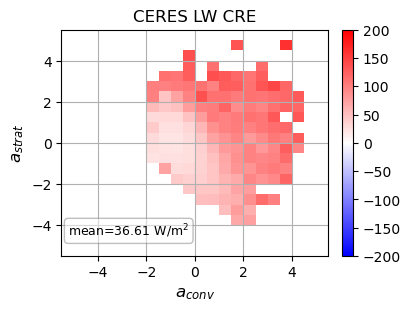

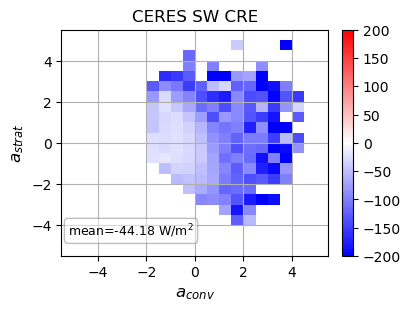

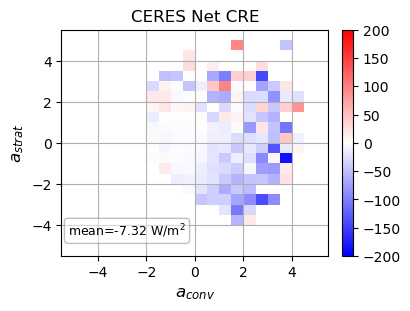

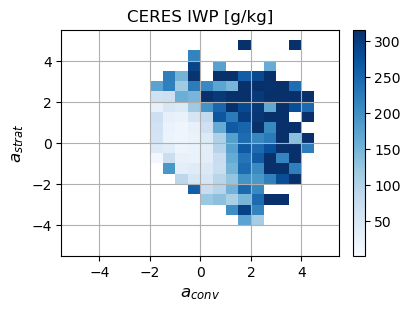

In [15]:
# Function to write the mean values
#
def _mean_text(ax, cre):
    ax.text(
        0.025, 0.15,
        fr'mean={np.nanmean(cre).item():.2f} W/m$^2$',
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='top',
        alpha=1,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.5", alpha=0.5)
    )
# Compute mean CREs
#
for cre, title in zip([ceres_lw_cre, ceres_sw_cre, ceres_net_cre], ['CERES LW CRE', 'CERES SW CRE', 'CERES Net CRE']):
    mean = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate first
        pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
        cre.data.ravel(), 
        statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
        bins=[pc_bins, pc_bins]
    ).statistic
    fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
    c = ax.pcolormesh(
        xmesh,
        ymesh,
        mean,
        norm=colors.TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200),
        cmap=plt.cm.bwr.copy()
    )
    _format_axis(ax)
    ax.set_title(title)
    _mean_text(ax, cre)
    fig.colorbar(c)
    out_name = "_".join(title.lower().split())
    save_figure(fig, f'{out_name}.pdf')

# Compute IWP
#
mean = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate first
        pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
        ceres_iwp.data.ravel(), 
        statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
        bins=[pc_bins, pc_bins]
    ).statistic
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=1e0, vmax=10**(2.5)),
    cmap=plt.cm.Blues.copy()
)
_format_axis(ax)
ax.set_title('CERES IWP [g/kg]')
fig.colorbar(c)
save_figure(fig, f'ceres_iwp.pdf')


# gSAM

In [7]:
# Load PCs
#
pcs = load_gsam_eofs_pcs().scores()
pcs = pcs/pcs.std(('lat', 'lon', 'time'))
# Load 2d data
#
data_2d = load_coarse_gsam_2d()
# Set bins for PCs and make plotting mesh
#
pc_bins = np.arange(-10, 10, 0.5)
xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))

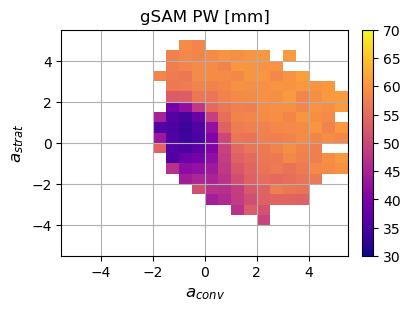

In [8]:
# Precipitable Water:
#
data_to_bin = data_2d['PW']
mean = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate first
    pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
    data_to_bin.data.ravel(), 
    statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
    bins=[pc_bins, pc_bins]
).statistic
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=30, vmax=70),
    cmap=plt.cm.plasma.copy()
)
_format_axis(ax)
fig.colorbar(c)
ax.set_title(f'gSAM PW [mm]')
save_figure(fig, 'gsam_pw.pdf')

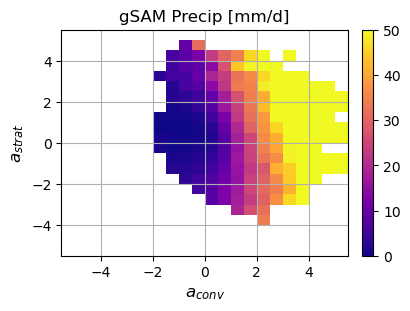

In [9]:
# Preicpitation:
#
data_to_bin = data_2d['Prec']
mean = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate first
    pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
    data_to_bin.data.ravel(), 
    statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
    bins=[pc_bins, pc_bins]
).statistic
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=0, vmax=50),
    cmap=plt.cm.plasma.copy()
)
_format_axis(ax)
fig.colorbar(c)
ax.set_title(f'gSAM Precip [mm/d]')
save_figure(fig, 'gsam_precip.pdf')

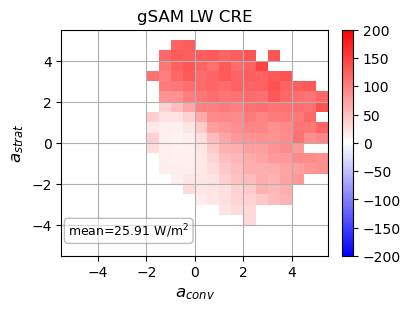

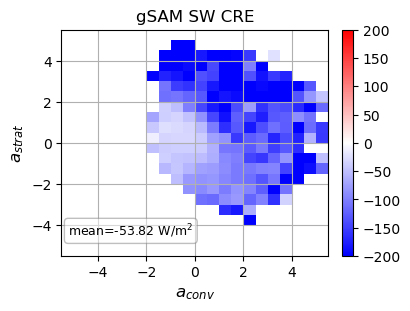

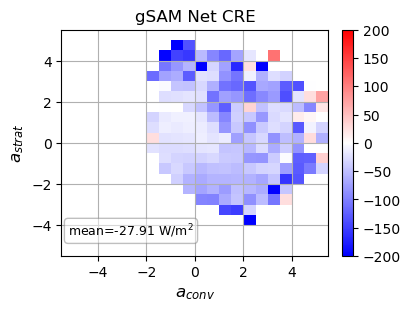

In [12]:
# gSAM CREs
#
gsam_lw_cre = data_2d.LWNTC - data_2d.LWNT
gsam_sw_cre = (-data_2d.SWNTC) - (-data_2d.SWNT)
gsam_net_cre = gsam_lw_cre + gsam_sw_cre
# Plot
#
def _mean_text(ax, cre):
    ax.text(
        0.025, 0.15,
        fr'mean={np.nanmean(cre).item():.2f} W/m$^2$',
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='top',
        alpha=1,
        bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.5", alpha=0.5)
    )
# Compute mean CREs
#
for cre, title in zip([gsam_lw_cre, gsam_sw_cre, gsam_net_cre], ['gSAM LW CRE', 'gSAM SW CRE', 'gSAM Net CRE']):
    mean = binned_statistic_2d(
        pcs.sel(mode=2).data.ravel(), # y-coordinate first
        pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
        cre.data.ravel(), 
        statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
        bins=[pc_bins, pc_bins]
    ).statistic
    fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
    c = ax.pcolormesh(
        xmesh,
        ymesh,
        mean,
        norm=colors.TwoSlopeNorm(vmin=-200, vcenter=0, vmax=200),
        cmap=plt.cm.bwr.copy()
    )
    _format_axis(ax)
    ax.set_title(title)
    _mean_text(ax, cre)
    fig.colorbar(c)
    out_name = "_".join(title.lower().split())
    save_figure(fig, f'{out_name}.pdf')

Text(0.5, 1.0, 'gSAM IWP [g/kg]')

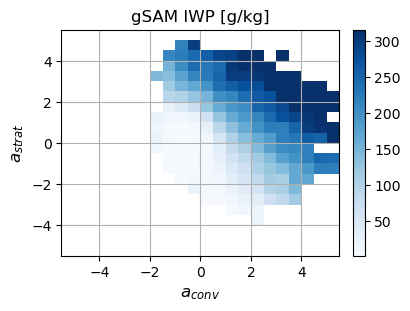

In [ ]:
# gSAM IWP
#
data_to_bin = 1000*data_2d['IWP']
mean = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate first
    pcs.sel(mode=1).data.ravel(), # x-coordinate seconds
    data_to_bin.data.ravel(), 
    statistic=lambda x: np.nanmean(x) if x.size > OBS_CUTOFF else np.nan, 
    bins=[pc_bins, pc_bins]
).statistic
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
c = ax.pcolormesh(
    xmesh,
    ymesh,
    mean,
    norm=colors.Normalize(vmin=1e0, vmax=10**(2.5)),
    cmap=plt.cm.Blues.copy()
)
_format_axis(ax)
fig.colorbar(c)
ax.set_title(f'gSAM IWP [g/kg]')
save_figure(fig, 'gsam_iwp.pdf')